# L3: Metadata Extraction and Chunking

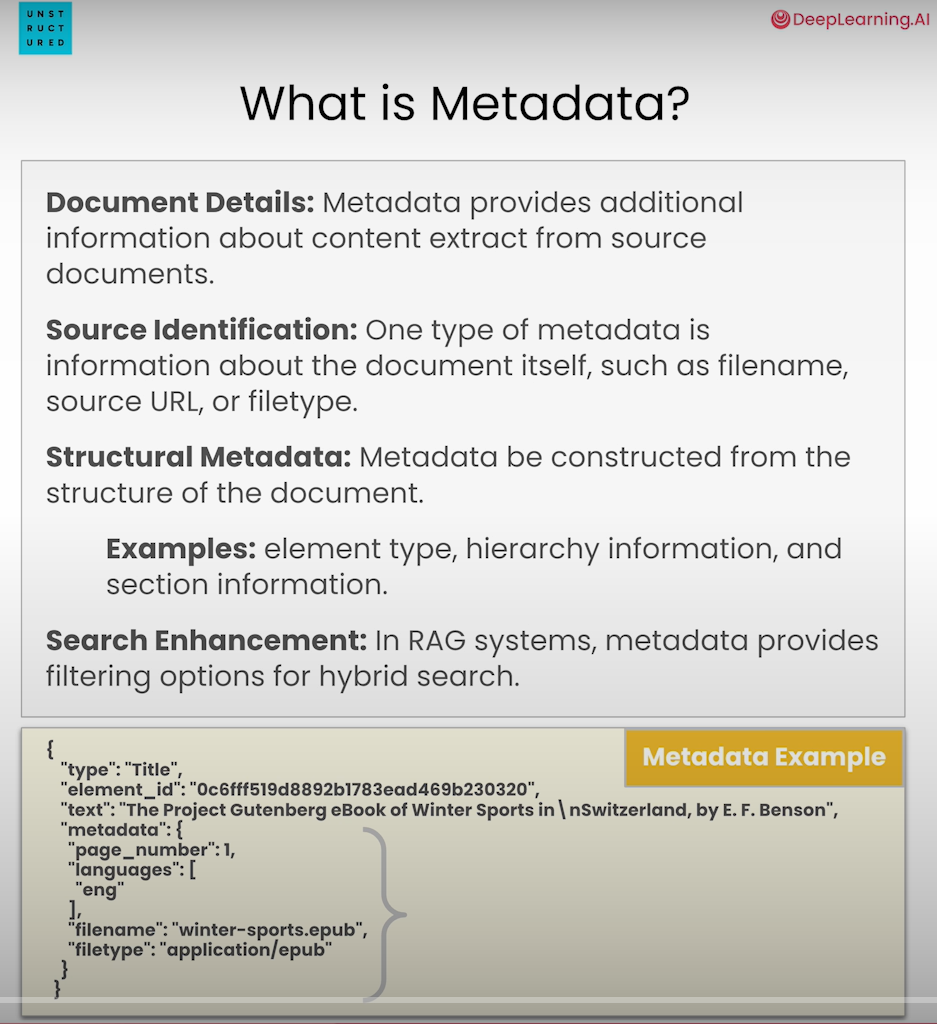

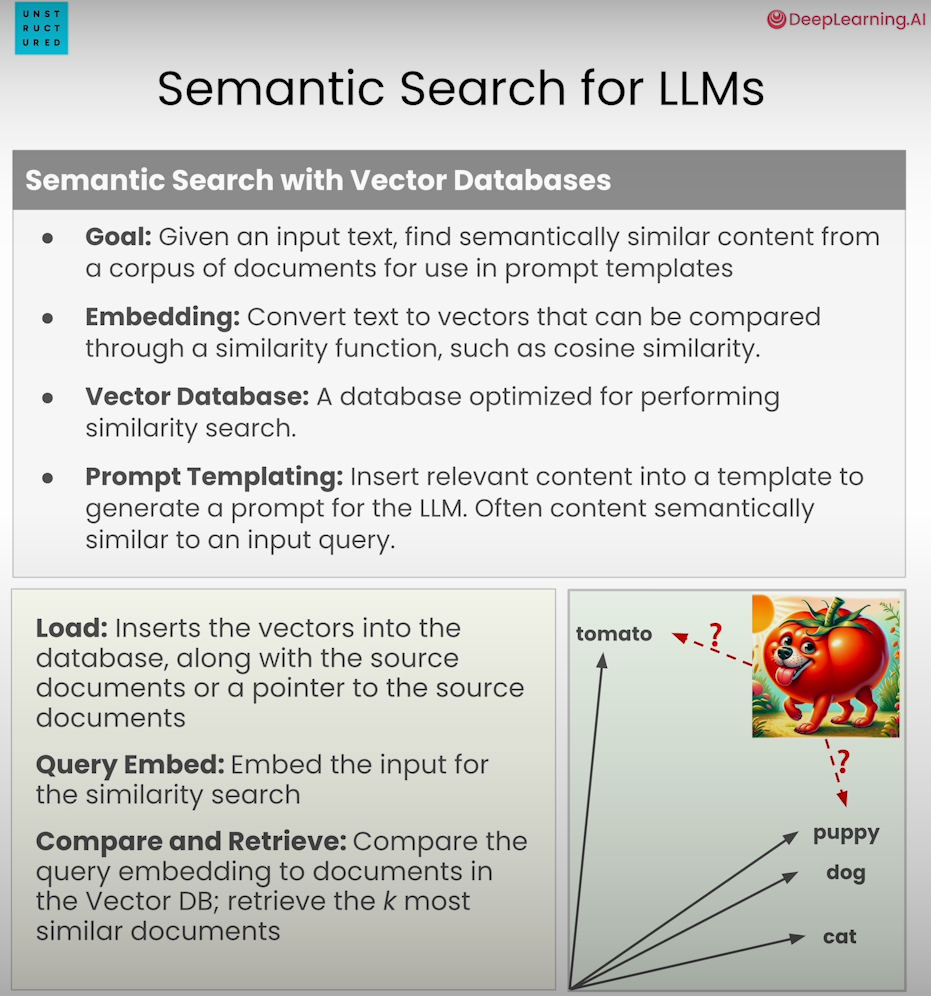

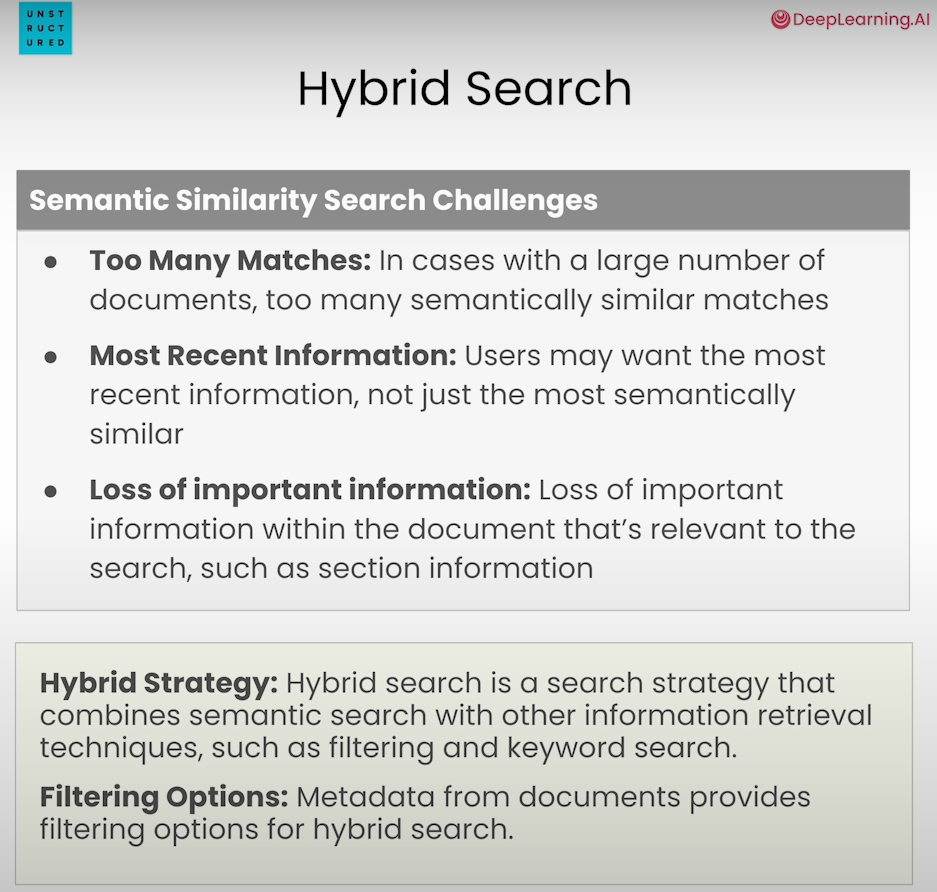

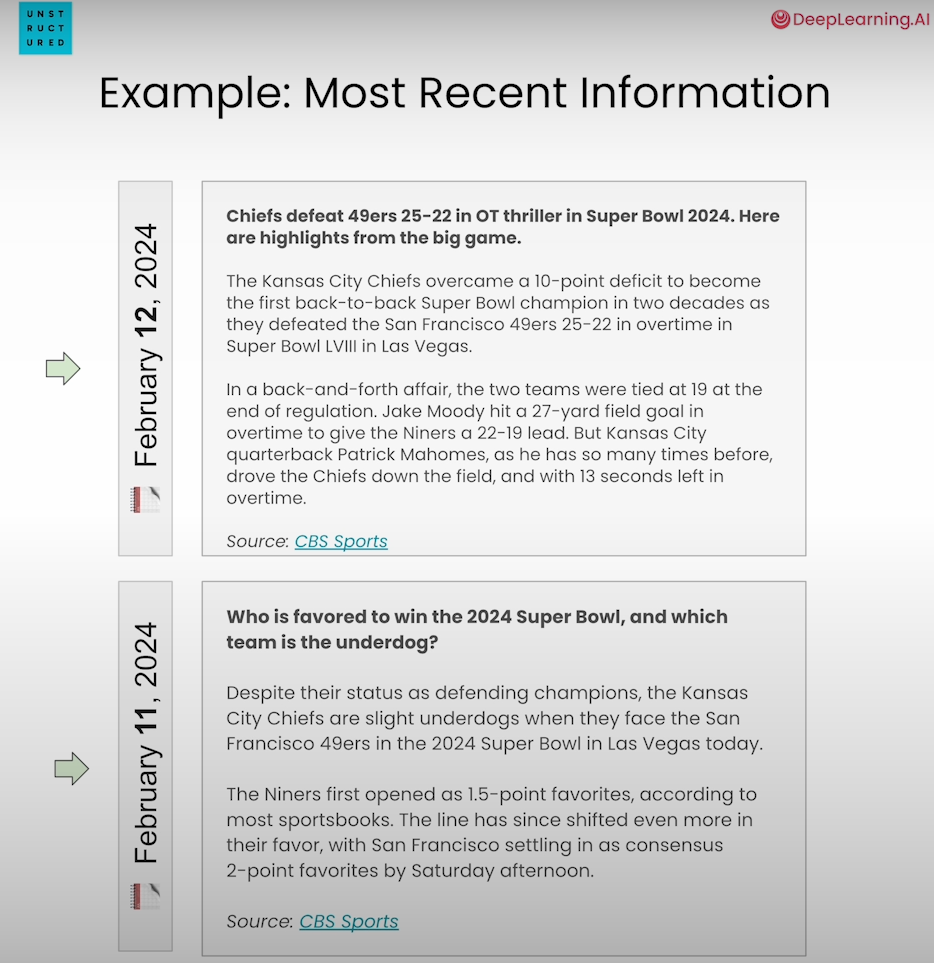

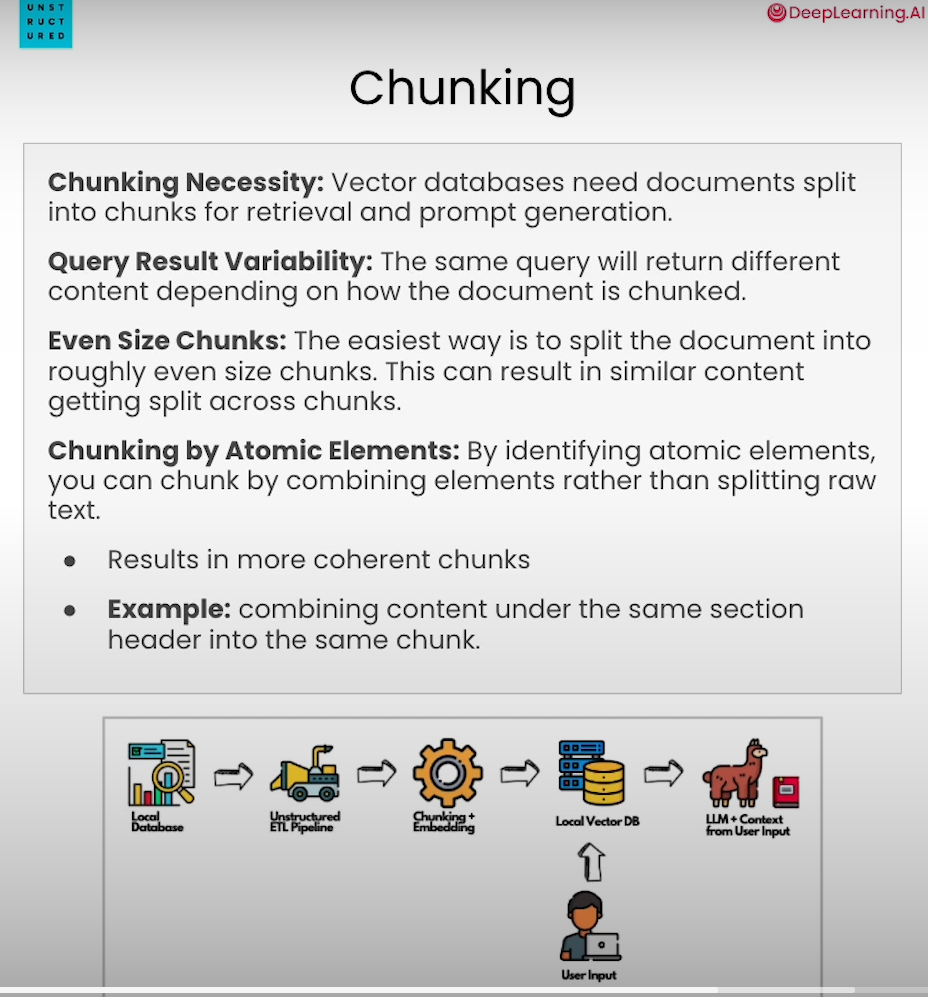

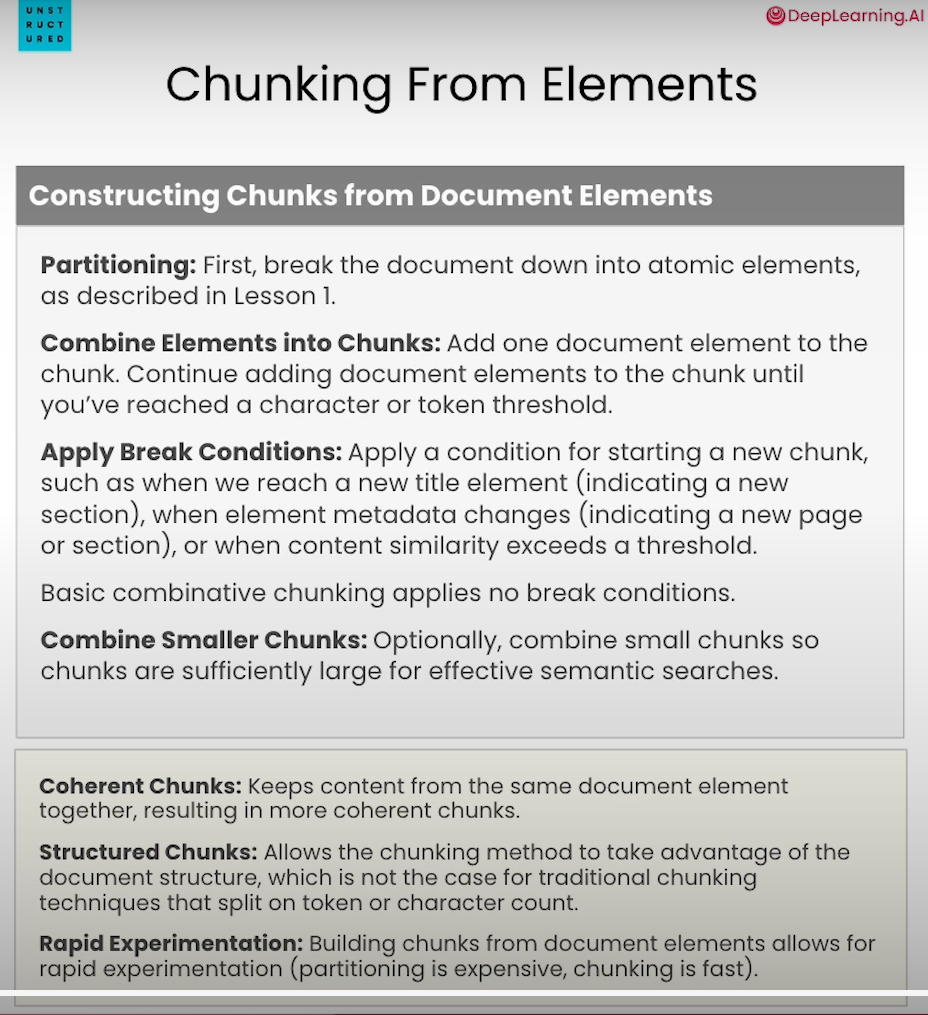

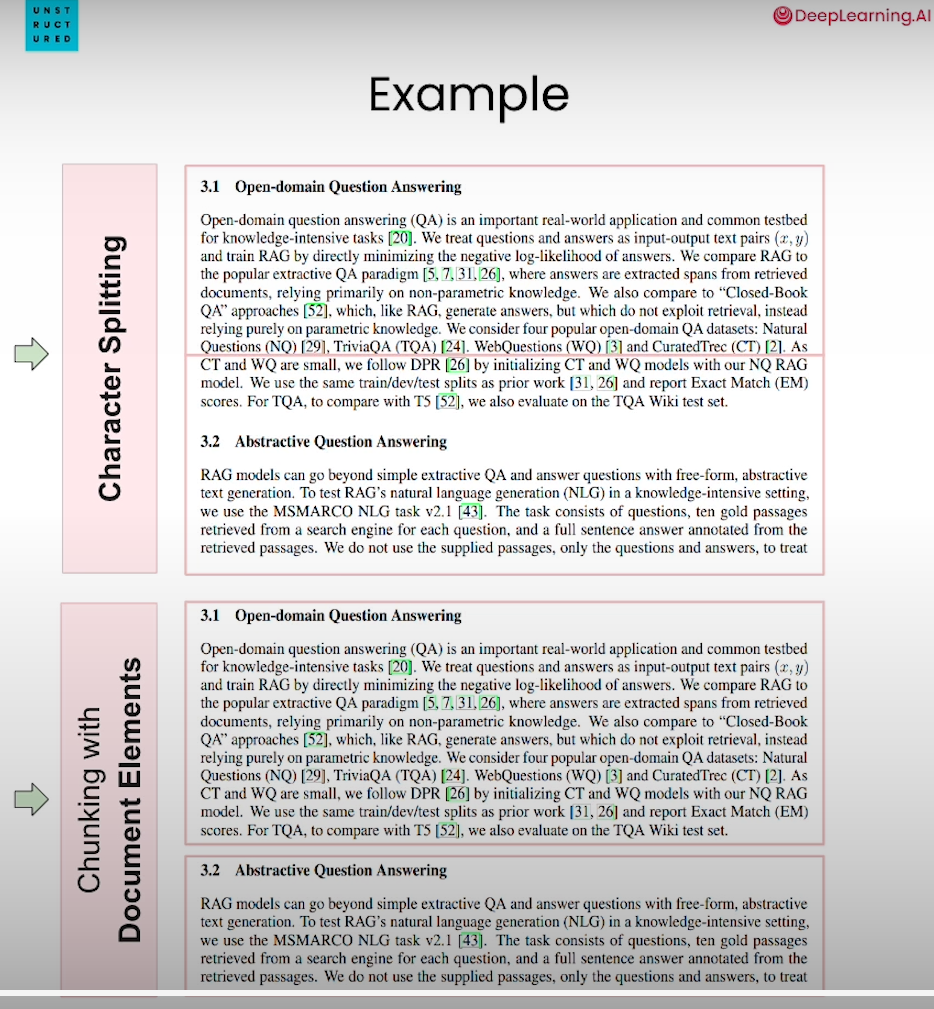

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [ ]:
import json
from IPython.display import JSON

from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.chunking.basic import chunk_elements
from unstructured.chunking.title import chunk_by_title
from unstructured.staging.base import dict_to_elements

import chromadb

In [ ]:
from Utils import Utils
utils = Utils()

DLAI_API_KEY = utils.get_dlai_api_key()
DLAI_API_URL = utils.get_dlai_url()

s = UnstructuredClient(
    api_key_auth=DLAI_API_KEY,
    server_url=DLAI_API_URL,
)

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Utils File and Helper Functions:</b> To access helper functions and other related files for this notebook, 1) click on the <em>"View"</em> option on the top menu of the notebook and then 2) click on <em>"File Browser"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


## Example Document: Winter Sports in Switzerland EPUB

In [ ]:
from IPython.display import Image
Image(filename='images/winter-sports-cover.png', height=400, width=400)

In [ ]:
Image(filename="images/winter-sports-toc.png", height=400, width=400) 

## View the content of the file
- <a href="example_files/winter-sports.pdf">Winter Sports (View PDF) -- Click Here</a>

## Run the document through the Unstructured API

In [ ]:
filename = "example_files/winter-sports.epub"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(files=files)

In [ ]:
try:
    resp = s.general.partition(req)
except SDKError as e:
    print(e)

In [ ]:
JSON(json.dumps(resp.elements[0:3], indent=2))

## Find elements associated with chapters

In [ ]:
[x for x in resp.elements if x['type'] == 'Title' and 'hockey' in x['text'].lower()]

In [ ]:
chapters = [
    "THE SUN-SEEKER",
    "RINKS AND SKATERS",
    "TEES AND CRAMPITS",
    "ICE-HOCKEY",
    "SKI-ING",
    "NOTES ON WINTER RESORTS",
    "FOR PARENTS AND GUARDIANS",
]

In [ ]:
chapter_ids = {}
for element in resp.elements:
    for chapter in chapters:
        if element["text"] == chapter and element["type"] == "Title":
            chapter_ids[element["element_id"]] = chapter
            break

In [ ]:
chapter_ids

In [ ]:
chapter_to_id = {v: k for k, v in chapter_ids.items()}
[x for x in resp.elements if x["metadata"].get("parent_id") == chapter_to_id["ICE-HOCKEY"]][0]

## Load documents into a vector db

In [ ]:
client = chromadb.PersistentClient(path="chroma_tmp", settings=chromadb.Settings(allow_reset=True))
client.reset()

In [ ]:
collection = client.create_collection(
    name="winter_sports",
    metadata={"hnsw:space": "cosine"}
)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Wait Time)</code>:</b> The following block can take a few minutes to complete.</p>

In [ ]:
for element in resp.elements:
    parent_id = element["metadata"].get("parent_id")
    chapter = chapter_ids.get(parent_id, "")
    collection.add(
        documents=[element["text"]],
        ids=[element["element_id"]],
        metadatas=[{"chapter": chapter}]
    )

## See the elements in Vector DB

In [ ]:
results = collection.peek()
print(results["documents"])

## Perform a hybrid search with metadata

In [ ]:
result = collection.query(
    query_texts=["How many players are on a team?"],
    n_results=2,
    where={"chapter": "ICE-HOCKEY"},
)
print(json.dumps(result, indent=2))

## Chunking Content

In [ ]:
elements = dict_to_elements(resp.elements)

In [ ]:
chunks = chunk_by_title(
    elements,
    combine_text_under_n_chars=100,
    max_characters=3000,
)

In [ ]:
JSON(json.dumps(chunks[0].to_dict(), indent=2))

In [ ]:
len(elements)

In [ ]:
len(chunks)

## Work With Your Own Files

In [ ]:
import panel as pn
#import param
from Utils import upld_file
pn.extension()

upld_widget = upld_file()
pn.Row(upld_widget.widget_file_upload)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 🖥 &nbsp; <b>Note:</b> If the file upload interface isn't functioning properly, the issue may be related to your browser version. In such a case, please ensure your browser is updated to the latest version, or try using a different browser.</p>


In [ ]:
!ls ./example_files

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Uploading Your Own File - Method 2:</b> To upload your own files, you can also 1) click on the <em>"View"</em> option on the top menu of the notebook and then 2) click on <em>"File Browser"</em>. Then 3) click on <em>"Upload"</em> button to upload your files. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>